# LRNet-Training

The training and evaluating codes for LRNet (Jupyter Notebook version).

Evironment: `PyTorch==1.8.0; cudatoolkit==11.0.221`

Created by FrederickSun at *2022-3-20*

Last updated at *2022-5-2*

## Preamble

In [1]:
import argparse
from tqdm.notebook import tqdm, trange
from torch import optim
from os.path import join
from utils.model import *
from utils.logger import Logger
from utils.metric import *
from utils.dataset import Dataset

Parameters Initialization

In [3]:
if_gpu = True
dataset_name = 'DF'
dataset_level = 'c23'
branch_selection = 'g1'

In [4]:
BLOCK_SIZE = 60
BATCH_SIZE = 1024
DROPOUT_RATE = 0.5
RNN_UNIT = 64
EPOCHS_g1 = 400
EPOCHS_g2 = 400
LEARNING_RATE = 0.005
add_weights = './weights/torch/'

## Preparation

In [5]:
"""
GPU
"""
if if_gpu:
    # Optional to uncomment if some bugs occur.
    # os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
    device = "cuda" if torch.cuda.is_available() else "cpu"
else:
    device = 'cpu'

"""
Dataset
"""
dataset = Dataset(name=dataset_name, level=dataset_level)

"""
Logs
"""
logger = Logger()
logger.register_status(dataset=dataset,
                       device=device,
                       add_weights=add_weights,
                       branch_selection=branch_selection)
logger.register_parameter(block_size=BLOCK_SIZE,
                          batch_size=BATCH_SIZE,
                          rnn_unit=RNN_UNIT,
                          epochs_g1=EPOCHS_g1,
                          epochs_g2=EPOCHS_g2,
                          learning_rate=LEARNING_RATE)
logger.print_logs_training()

==        LOG        ==


#-------Status--------#
Using device:  cuda
Dataset name:  DF
Dataset compression level:  c23
Directory of real samples:  ['./datasets/Origin/c23']
Directory of fake samples:  ['./datasets/DF/c23']
Directory of model weights:  ./weights/test/
Which branch of the LRNet to be trained:  g1
#-----Status End------#


#-----Parameters------#
Block size (frames per sample):  60
Batch size:  1024
RNN hidden units:  64
Training epochs (g1):  400
Training epochs (g2):  20
Learning rate  0.005
#---Parameters End----#


==      LOG END      ==


### load dataset

In [9]:
"""
Loading data
"""
train_iter_A = None
train_iter_B = None
test_iter_A = None
test_iter_B = None
if branch_selection == 'g1':
    train_iter_A = dataset.load_data_train_g1(BLOCK_SIZE, BATCH_SIZE)
    test_iter_A, test_labels, test_labels_video, test_sv, test_vc = \
        dataset.load_data_test_g1(BLOCK_SIZE, BATCH_SIZE)
elif branch_selection == 'g2':
    train_iter_B = dataset.load_data_train_g2(BLOCK_SIZE, BATCH_SIZE)
    test_iter_B, test_labels, test_labels_video, test_sv, test_vc = \
        dataset.load_data_test_g2(BLOCK_SIZE, BATCH_SIZE)
elif branch_selection == 'all':
    train_iter_A, train_iter_B = dataset.load_data_train_all(BLOCK_SIZE, BATCH_SIZE)
    test_iter_A, test_iter_B, test_labels, test_labels_video, test_sv, test_vc = \
        dataset.load_data_test_all(BLOCK_SIZE, BATCH_SIZE)
else:
    print("Unknown branch selection:", branch_selection, '. Please check and restart')

  1%|          | 5/800 [00:00<00:18, 43.05it/s]

Loading data from:  ./datasets/Origin/c23/train/


  1%|          | 4/797 [00:00<00:25, 31.40it/s]

Loading data from:  ./datasets/DF/c23/train/


  2%|▎         | 5/200 [00:00<00:04, 42.28it/s]

Loading data from:  ./datasets/Origin/c23/test/


  2%|▏         | 4/200 [00:00<00:05, 32.94it/s]

Loading data from:  ./datasets/DF/c23/test/


100%|██████████| 200/200 [00:06<00:00, 32.30it/s]


## Train

Train loop function

In [56]:
def train_loop(model, train_iter, test_iter, optimizer, loss, epochs, device, add_weights_file):
    log_training_loss = []
    log_training_accuracy = []
    log_testing_accuracy = []
    best_test_acc = 0.0

    model.to(device)
    model.train()
    for epoch in trange(1, epochs + 1):
        loss_sum, acc_sum, samples_sum = 0.0, 0.0, 0
        for X, y in train_iter:
            # Load data to GPU/cpu
            X = X.to(device)
            y = y.to(device)
            samples_num = X.shape[0]

            # BP
            output = model(X)
            log_softmax_output = torch.log(output)
            l = loss(log_softmax_output, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            # Generating Log
            loss_sum += l.item() * samples_num
            acc_sum += calculate_accuracy(output, y) * samples_num
            samples_sum += samples_num

        test_acc = evaluate(model, test_iter, device)
        if test_acc >= best_test_acc:
            save_hint = "save the model to {}".format(add_weights_file)
            torch.save(model.state_dict(), add_weights_file)
            best_test_acc = test_acc
        else:
            save_hint = " "*60
        
        tqdm.write("\repoch:{}, loss:{:.4}, train_acc:{:.4}, test_acc:{:.4}, best_record:{:.4}  "
                   .format(epoch, loss_sum/samples_sum, acc_sum/samples_sum, test_acc, best_test_acc)
                   + save_hint, end='')

        log_training_loss.append(loss_sum/samples_sum)
        log_training_accuracy.append(acc_sum/samples_sum)
        log_testing_accuracy.append(test_acc)

    log = {"loss": log_training_loss, "acc_train": log_training_accuracy, "acc_test": log_testing_accuracy}
    return log

### g1-training

In [59]:
if branch_selection == 'g1' or branch_selection == 'all':
    assert train_iter_A, test_iter_A is not None
    g1 = LRNet(RNN_UNIT, DROPOUT_RATE)
    optimizer = optim.Adam(g1.parameters(), lr=LEARNING_RATE)
    loss = nn.NLLLoss()
    add_weights_file = join(add_weights, 'g1.pth')
    log_g1 = train_loop(g1, train_iter_A, test_iter_A, optimizer, loss, EPOCHS_g1, device, add_weights_file)
    print("\nThe model weights are saved at: ", add_weights_file)

  0%|          | 0/400 [00:00<?, ?it/s]

epoch:400, loss:0.2863, train_acc:0.8843, test_acc:0.9013, best_record:0.9079                                                              
The model weights are saved at:  ./weights/test/g1.pth


In [58]:
print(g1)

LRNet(
  (dropout_landmark): LandmarkDropout()
  (gru): GRU(136, 64, batch_first=True, bidirectional=True)
  (dropout_feature_1): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (dropout_feature_2): Dropout(p=0.5, inplace=False)
  (linear_2): Linear(in_features=64, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


### g2-training

In [ ]:
if branch_selection == 'g2' or branch_selection == 'all':
    assert train_iter_B, test_iter_B is not None
    g2 = LRNet(RNN_UNIT, DROPOUT_RATE)
    optimizer = optim.Adam(g2.parameters(), lr=LEARNING_RATE)
    loss = nn.NLLLoss()
    add_weights_file = join(add_weights, 'g2.pth')
    log_g2 = train_loop(g2, train_iter_B, test_iter_B, optimizer, loss, EPOCHS_g2, device, add_weights_file)
    print("\nThe model weights are saved at: ", add_weights_file)

In [ ]:
print(g2)

# LRNet-Evaluating

## Preamble

In [1]:
import argparse
from tqdm.notebook import tqdm, trange
from torch import optim
from os.path import join
from utils.model import *
from utils.logger import Logger
from utils.metric import *
from utils.dataset import Dataset
from sklearn.metrics import roc_curve, auc

Parameters Initialization

In [2]:
if_gpu = True
dataset_name = 'FF_all'
dataset_level = 'c23'
branch_selection = 'all'

In [3]:
BLOCK_SIZE = 60
BATCH_SIZE = 1024
DROPOUT_RATE = 0.5
RNN_UNIT = 64
add_weights = './weights/torch/'
weights_name_g1 = 'g1_all.pth'
weights_name_g2 = 'g2_all.pth'

## Preparation

In [4]:
"""
GPU
"""
if if_gpu:
    # Optional to uncomment if some bugs occur.
    # os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
    device = "cuda" if torch.cuda.is_available() else "cpu"
else:
    device = 'cpu'

"""
Dataset
"""
dataset = Dataset(name=dataset_name, level=dataset_level)

"""
Logs
"""
logger = Logger()
logger.register_status(dataset=dataset,
                       device=device,
                       add_weights=add_weights,
                       branch_selection=branch_selection)
logger.print_logs_evaluating()

==        LOG        ==


#-------Status--------#
Using device:  cuda
Dataset name:  FF_all
Dataset compression level:  c23
Directory of real samples:  ['./datasets/Origin/c23', './datasets/Origin/c23', './datasets/Origin/c23', './datasets/Origin/c23']
Directory of fake samples:  ['./datasets/DF/c23', './datasets/NT/c23', './datasets/F2F/c23', './datasets/FS/c23']
Directory of model weights:  ./weights/torch/
Which branch of the LRNet to be evaluated:  all
#-----Status End------#


==      LOG END      ==


### load dataset

In [5]:
"""
Loading data
"""
test_iter_A = None
test_iter_B = None
if branch_selection == 'g1':
    test_iter_A, test_labels, test_labels_video, test_sv, test_vc = \
        dataset.load_data_test_g1(BLOCK_SIZE, BATCH_SIZE)
elif branch_selection == 'g2':
    test_iter_B, test_labels, test_labels_video, test_sv, test_vc = \
        dataset.load_data_test_g2(BLOCK_SIZE, BATCH_SIZE)
elif branch_selection == 'all':
    test_iter_A, test_iter_B, test_labels, test_labels_video, test_sv, test_vc = \
        dataset.load_data_test_all(BLOCK_SIZE, BATCH_SIZE)
else:
    print("Unknown branch selection:", branch_selection, '. Please check and restart')

  2%|▎         | 5/200 [00:00<00:04, 43.11it/s]

Loading data from:  ./datasets/Origin/c23/test/


  2%|▏         | 4/200 [00:00<00:05, 38.49it/s]

Loading data from:  ./datasets/DF/c23/test/


  3%|▎         | 6/200 [00:00<00:03, 56.68it/s]

Loading data from:  ./datasets/NT/c23/test/


  2%|▎         | 5/200 [00:00<00:04, 44.77it/s]

Loading data from:  ./datasets/F2F/c23/test/


  3%|▎         | 6/200 [00:00<00:03, 56.63it/s]

Loading data from:  ./datasets/FS/c23/test/


100%|██████████| 200/200 [00:03<00:00, 53.81it/s]


## Evaluate

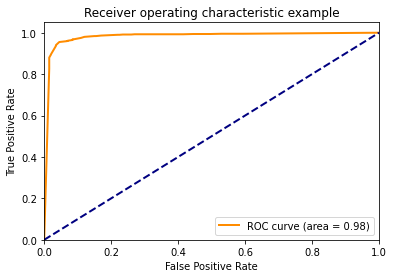



#----Evaluation  Results----#
Evaluation (g1_all.pth) - Acc: 0.88
Evaluation (g2_all.pth) - Acc: 0.9154
Accuracy (sample-level): 0.9216
Accuracy (video-level): 0.957
AUC (video-level): 0.9813
#------------End------------#


In [6]:
g1 = None
g2 = None
acc_g1 = None
acc_g2 = None
if branch_selection == 'g1' or branch_selection == 'all':
    g1 = LRNet(RNN_UNIT, DROPOUT_RATE)
    g1.load_state_dict(torch.load(join(add_weights, weights_name_g1)))
    acc_g1 = evaluate(g1, test_iter_A, device)

if branch_selection == 'g2' or branch_selection == 'all':
    g2 = LRNet(RNN_UNIT, DROPOUT_RATE)
    g2.load_state_dict(torch.load(join(add_weights, weights_name_g2)))
    acc_g2 = evaluate(g2, test_iter_B, device)

"""
Evaluate the [g1+g2] merged prediction (sample-level and video-level).
If only evaluating the single branch, the sample-level evaluation 
    will be SKIPPED because it's equal to acc_g1 or acc_g2.
Also, at this situation, the 'mix_predict' will be 
    directly equal to prediction or prediction_diff.
"""
# ----Sample-level----#
count_s = None
total_s = None
if branch_selection == 'g1':
    prediction = predict(g1, test_iter_A, device)
    mix_predict = list(prediction[:, 1])
elif branch_selection == 'g2':
    prediction_diff = predict(g2, test_iter_B, device)
    mix_predict = list(prediction_diff[:, 1])
else:
    prediction = predict(g1, test_iter_A, device)
    prediction_diff = predict(g2, test_iter_B, device)
    count_s = 0
    total_s = test_labels.shape[0]
    mix_predict = []
    for i in range(len(prediction)):
        mix = prediction[i][1] + prediction_diff[i][1]
        if mix >= 1:
            result = 1
        else:
            result = 0
        if result == test_labels[i]:
            count_s += 1
        mix_predict.append(mix / 2)

# ----Video-level----#
prediction_video = merge_video_prediction(mix_predict, test_sv, test_vc)
count_v = 0
total_v = len(test_labels_video)
for i, pd in enumerate(prediction_video):
    if pd >= 0.5:
        result = 1
    else:
        result = 0
    if result == test_labels_video[i]:
        count_v += 1

# For AUC evaluation
fpr, tpr, _ = roc_curve(test_labels_video, prediction_video)
roc_auc = auc(fpr, tpr)
plot_ROC(fpr, tpr, roc_auc)

"""
Exhibit the evaluation results.
"""
print("\n")
print("#----Evaluation  Results----#")
if branch_selection == 'g1' or branch_selection == 'all':
    print("Evaluation ({}) - Acc: {:.4}".format(weights_name_g1, acc_g1))
if branch_selection == 'g2' or branch_selection == 'all':
    print("Evaluation ({}) - Acc: {:.4}".format(weights_name_g2, acc_g2))
if branch_selection == 'all':
    print("Accuracy (sample-level): {:.4}".format(count_s / total_s))
print("Accuracy (video-level): {:.4}".format(count_v / total_v))
print("AUC (video-level): {:.4}".format(roc_auc))
print("#------------End------------#")